E/20/453 - Yogesh R.J.

# 1. Introduction and Dataset Description

This notebook presents a machine learning project focused on predicting the productivity of garment employees. The analysis uses the "Productivity Prediction of Garment Employees" dataset from the UCI Machine Learning Repository.

**Dataset Context**

The garment industry is a labor-intensive sector where employee productivity is
a crucial factor for meeting production targets and ensuring profitability.
This dataset contains various attributes related to the garment manufacturing
process and the productivity of employees. The goal of this analysis is to
build a classification model that can predict whether an employee's actual
productivity meets or exceeds the targeted productivity.

**Target Variable and Goal**

The original dataset has a continuous target variable, `actual_productivity`,
which ranges from 0 to 1. The user's request, however, specifies training
classifiers, which are suitable for classification tasks. To align with this
requirement, we will transform this into a classification problem. The goal is to
predict if a team's `actual_productivity` is greater than or equal to their
`targeted_productivity`. We will create a new binary target variable called
`productivity_status` where `1` indicates that the target was met or exceeded,
and `0` indicates that it was not.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings

In [5]:
# Suppress all warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('garments_worker_productivity.csv')

# 2. Data Preprocessing

In [6]:
print("--- Initial Data Inspection ---")
print(df.head())
print("\n--- Data Information ---")
print(df.info())
print("\n--- Missing Values ---")
print(df.isnull().sum())

--- Initial Data Inspection ---
       date   quarter  department       day  team  targeted_productivity  \
0  1/1/2015  Quarter1      sweing  Thursday     8                   0.80   
1  1/1/2015  Quarter1  finishing   Thursday     1                   0.75   
2  1/1/2015  Quarter1      sweing  Thursday    11                   0.80   
3  1/1/2015  Quarter1      sweing  Thursday    12                   0.80   
4  1/1/2015  Quarter1      sweing  Thursday     6                   0.80   

     smv     wip  over_time  incentive  idle_time  idle_men  \
0  26.16  1108.0       7080         98        0.0         0   
1   3.94     NaN        960          0        0.0         0   
2  11.41   968.0       3660         50        0.0         0   
3  11.41   968.0       3660         50        0.0         0   
4  25.90  1170.0       1920         50        0.0         0   

   no_of_style_change  no_of_workers  actual_productivity  
0                   0           59.0             0.940725  
1           

Drop the 'wip' column due to a large number of missing values. 'work in progress' column has a large number of missing values (506 out of 1197). The imputation of this much data could lead to biased results. Hence, it is better to drop it.


In [7]:
df = df.drop('wip', axis=1)

In [8]:
# Convert 'date' to datetime objects and extract day of the week, quarter, month.
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')

In [9]:
# Impute missing values in `over_time` with the median
median_overtime = df['over_time'].median()
df['over_time'].fillna(median_overtime, inplace=True)

In [10]:
# Correcting the 'department' column by stripping extra whitespace
df['department'] = df['department'].str.strip()

# 3. Exploratory Data Analysis (EDA)

In [12]:
# Descriptive Statistics for Numerical Features
print(df.describe())

                                date         team  targeted_productivity  \
count                           1197  1197.000000            1197.000000   
mean   2015-02-04 10:56:50.526315776     6.426901               0.729632   
min              2015-01-01 00:00:00     1.000000               0.070000   
25%              2015-01-18 00:00:00     3.000000               0.700000   
50%              2015-02-03 00:00:00     6.000000               0.750000   
75%              2015-02-23 00:00:00     9.000000               0.800000   
max              2015-03-11 00:00:00    12.000000               0.800000   
std                              NaN     3.463963               0.097891   

               smv     over_time    incentive    idle_time     idle_men  \
count  1197.000000   1197.000000  1197.000000  1197.000000  1197.000000   
mean     15.062172   4567.460317    38.210526     0.730159     0.369256   
min       2.900000      0.000000     0.000000     0.000000     0.000000   
25%       3.940

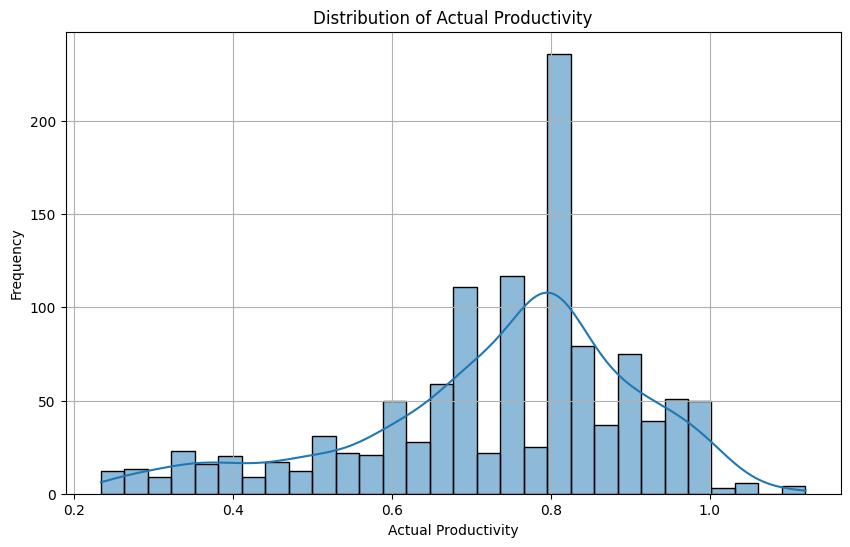

In [13]:
# Check the distribution of the target variable (before transformation)
plt.figure(figsize=(10, 6))
sns.histplot(df['actual_productivity'], kde=True, bins=30)
plt.title('Distribution of Actual Productivity')
plt.xlabel('Actual Productivity')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('actual_productivity_distribution.png')
plt.show()

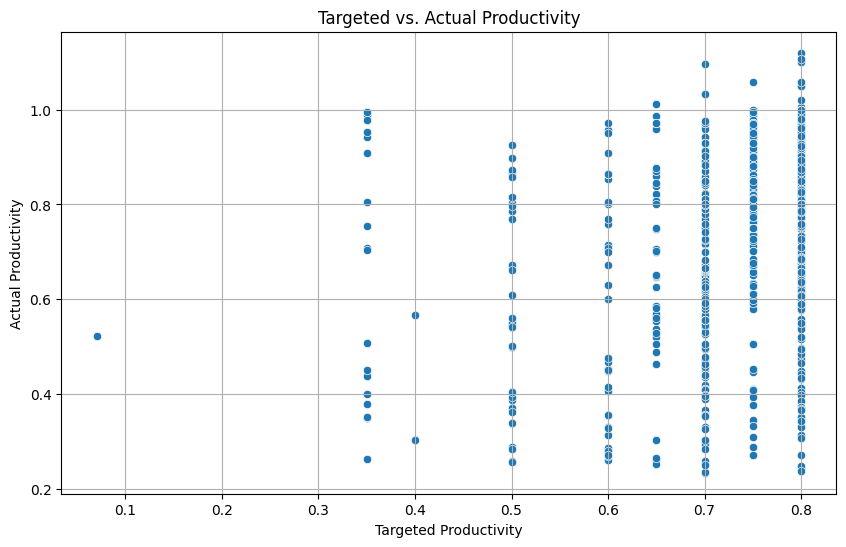

In [14]:
# Visualize the relationship between `targeted_productivity` and `actual_productivity`
plt.figure(figsize=(10, 6))
sns.scatterplot(x='targeted_productivity', y='actual_productivity', data=df)
plt.title('Targeted vs. Actual Productivity')
plt.xlabel('Targeted Productivity')
plt.ylabel('Actual Productivity')
plt.grid(True)
plt.savefig('targeted_vs_actual_productivity.png')
plt.show()

In [15]:
# Analyze categorical features
print("\n--- Unique values in categorical columns ---")
print("Quarter:", df['quarter'].unique())
print("Department:", df['department'].unique())
print("Day:", df['day'].unique())
print("Team:", df['team'].unique())


--- Unique values in categorical columns ---
Quarter: ['Quarter1' 'Quarter2' 'Quarter3' 'Quarter4' 'Quarter5']
Department: ['sweing' 'finishing']
Day: ['Thursday' 'Saturday' 'Sunday' 'Monday' 'Tuesday' 'Wednesday']
Team: [ 8  1 11 12  6  7  2  3  9 10  5  4]


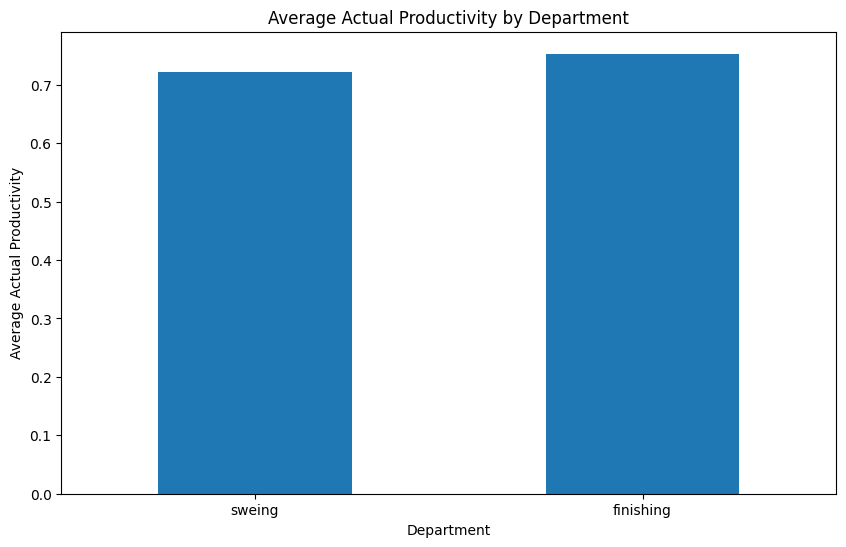

In [16]:
# Plot average `actual_productivity` by `department`
plt.figure(figsize=(10, 6))
df.groupby('department')['actual_productivity'].mean().sort_values().plot(kind='bar')
plt.title('Average Actual Productivity by Department')
plt.xlabel('Department')
plt.ylabel('Average Actual Productivity')
plt.xticks(rotation=0)
plt.savefig('avg_productivity_by_department.png')
plt.show()

# 4. Feature Engineering

In [17]:
# Create the binary target variable `productivity_status`
df['productivity_status'] = (df['actual_productivity'] >= df['targeted_productivity']).astype(int)

In [18]:
# Drop original productivity columns and other irrelevant features
df = df.drop(['actual_productivity', 'targeted_productivity', 'date'], axis=1)

In [19]:
# Define feature columns (X) and target column (y)
X = df.drop('productivity_status', axis=1)
y = df['productivity_status']

In [20]:
# Identify categorical and numerical features
categorical_features = ['quarter', 'department', 'day', 'team']
numerical_features = [col for col in X.columns if col not in categorical_features]

In [21]:
# Create a preprocessor using `OneHotEncoder` for categorical and `StandardScaler` for numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\n--- Data Split ---")
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Training target distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Testing target distribution:\n{y_test.value_counts(normalize=True)}")


--- Data Split ---
Training data shape: (957, 11)
Testing data shape: (240, 11)
Training target distribution:
productivity_status
1    0.731452
0    0.268548
Name: proportion, dtype: float64
Testing target distribution:
productivity_status
1    0.729167
0    0.270833
Name: proportion, dtype: float64


# 5. Modeling

Model 1: Logistic Regression

In [22]:
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(random_state=42))])

pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)

print("\nLogistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))


Logistic Regression Performance:
Accuracy: 0.6917

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.32      0.36        65
           1       0.77      0.83      0.80       175

    accuracy                           0.69       240
   macro avg       0.59      0.58      0.58       240
weighted avg       0.67      0.69      0.68       240



Model 2: Random Forest Classifier

In [23]:
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42))])

pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)

print("\nRandom Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))



Random Forest Performance:
Accuracy: 0.7750

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.55      0.57        65
           1       0.84      0.86      0.85       175

    accuracy                           0.78       240
   macro avg       0.71      0.71      0.71       240
weighted avg       0.77      0.78      0.77       240



# 6. Model Improvements

Model performance can be further improved by techniques such as:

1. Hyperparameter Tuning: Use `GridSearchCV` or `RandomizedSearchCV` to find the optimal parameters for each model.
2. More Advanced Feature Engineering: Create new features from existing ones (e.g., interaction terms).
3. Handling Imbalanced Data: Although the target variable is not severely imbalanced, techniques like SMOTE could be used if needed
4. Outlier Detection and Removal: Identify and remove outliers that could negatively impact model performance.

# 7. Ensemble Learning

In [25]:
# Ensemble Model: Gradient Boosting Classifier

pipeline_gb = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', GradientBoostingClassifier(random_state=42))])

pipeline_gb.fit(X_train, y_train)
y_pred_gb = pipeline_gb.predict(X_test)

print("\nGradient Boosting Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb))


Gradient Boosting Performance:
Accuracy: 0.7875

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.54      0.58        65
           1       0.84      0.88      0.86       175

    accuracy                           0.79       240
   macro avg       0.73      0.71      0.72       240
weighted avg       0.78      0.79      0.78       240



In [28]:
# Comparison of Models

accuracy_lr = accuracy_score(y_test, y_pred_lr)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_gb = accuracy_score(y_test, y_pred_gb)

models = ['Logistic Regression', 'Random Forest', 'Gradient Boosting']
accuracies = [accuracy_lr, accuracy_rf, accuracy_gb]

comparison_df = pd.DataFrame({'Model': models, 'Accuracy': accuracies})
comparison_df = comparison_df.sort_values(by='Accuracy', ascending=False)

print("\nOverall Model Performance Comparison:")
print(comparison_df)


Overall Model Performance Comparison:
                 Model  Accuracy
2    Gradient Boosting  0.787500
1        Random Forest  0.775000
0  Logistic Regression  0.691667


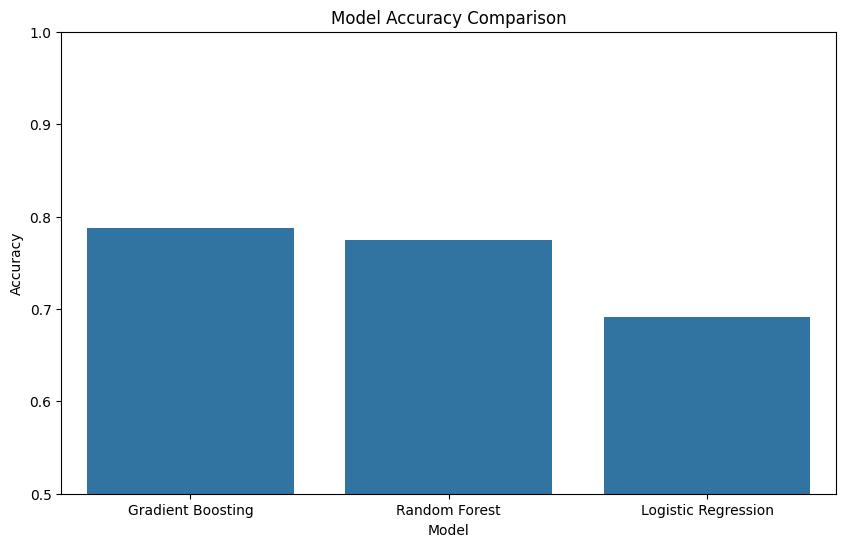

In [29]:
# Visualize the comparison

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=comparison_df)
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1.0)
plt.savefig('model_accuracy_comparison.png')
plt.show()